# Setup

In [1]:
import json
import os
import sys
import warnings

sys.path.append('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import balanced_accuracy_score, recall_score, mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV
from sklearn.dummy import DummyRegressor

from verde import BlockKFold

from pymer4 import Lmer
from flaml import AutoML

from utils import read_csv_non_utf
from model_utils import HurdleModelEstimator, PymerModelWrapper
from custom_metrics import balanced_accuracy_FLAML, mean_absolute_error_range
from cross_validation import run_cross_val, save_cv_results

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']
ferreiro_arias2024 = config['indiv_data_paths']['ferreiro_arias2024']

ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)
fer_ari_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, ferreiro_arias2024)

In [3]:
# Choosing the dataset - "mammals" or "birds"
dataset = 'mammals'

# Reading in the dataset
if dataset == 'birds':
    data = pd.read_csv(fer_ari_path)
elif dataset == 'mammals':
    data = read_csv_non_utf(ben_lop_path)

data.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


# Running the cross-validation

In [4]:
# Defining the metrics to use
class_metrics = {'per_class' : {'balanced_accuracy' : {'function' : balanced_accuracy_score,
                                                       'kwargs' : {}
                                                      },
                                'sensitivity' : {'function' : recall_score,
                                                 'kwargs' : {'pos_label' : 1}
                                                 },
                                'specificity' : {'function' : recall_score,
                                                 'kwargs' : {'pos_label' : 0}
                                                 }
                               },
                  'overall' : {'balanced_accuracy_overall' : {'function' : balanced_accuracy_score,
                                                              'kwargs' : {}
                                                             }
                              }
                }
reg_metrics = {'mean_absolute_error' : {'function' : mean_absolute_error,
                                        'kwargs' : {}
                                       },
               'root_mean_squared_error' : {'function' : root_mean_squared_error,
                                            'kwargs' : {}
                                           },
               'mean_absolute_error_0-1' : {'function' : mean_absolute_error_range,
                                            'kwargs' : {'lower_bound' : 0,
                                                        'upper_bound' : 1
                                                       }
                                           }
              }

In [6]:
# Choosing the model to use, among pymer, sklearn, FLAML_hurdle, FLAML_regression, FLAML_classification
model_to_use = 'FLAML_hurdle'
vals_to_save = ['metrics', 'raw']

# General cross-validation params
num_folds = 5
block_type = 'spatial'
group_col = None
spatial_spacing = 5

# Pymer hurdle model, for sanity checking
if model_to_use == 'pymer':
    #  setting up the equations for each model
    if dataset == 'mammals':
        formula_zero = 'local_extirpation ~ BM + DistKm + I(DistKm^2) + PopDens + Stunting + Reserve + (1|Country) + (1|Species) + (1|Study)'
        formula_nonzero = 'RR ~ BM + DistKm + I(DistKm^2) + PopDens + I(PopDens^2) + BM*DistKm + (1|Country) + (1|Species) + (1|Study)'
    elif dataset == 'birds':
        formula_zero = 'local_extirpation ~ Body_Mass + Dist_Hunters + TravDist + PopDens + Stunting + NPP + Reserve + Body_Mass*Dist_Hunters + Body_Mass*TravDist + Body_Mass*Stunting + NPP*Dist_Hunters + (1|Country) + (1|Species)'
        formula_nonzero = 'RR ~ Body_Mass + Dist_Hunters + TravDist + PopDens + Stunting + NPP + Reserve + Body_Mass*Dist_Hunters + Body_Mass*TravDist + Body_Mass*Stunting + NPP*Dist_Hunters + (1|Country) + (1|Species)'
    
    control_str = "optimizer='bobyqa', optCtrl=list(maxfun=1e5)"

    #  hurdle model params
    use_rfx = False
    extirp_pos = False

    outlier_cutoff = 15 if dataset == 'mammals' else 5
    data_args = {'outlier_cutoff' : outlier_cutoff, 'dataset' : dataset}

    #  setting up the hurdle model
    zero_model = PymerModelWrapper(Lmer, formula = formula_zero, family = 'binomial', control_str = control_str, 
                                   use_rfx = use_rfx)
    nonzero_model = PymerModelWrapper(Lmer, formula = formula_nonzero, family = 'gaussian', use_rfx = use_rfx)

    model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, data_args = data_args)

    #  cross-validation params
    back_transform = True
    sklearn_submodels = False
    direct = None
    tune_hurdle_thresh = True
    
    fit_args = None
    pp_args = {'include_indicators' : False,
               'include_categorical' : True,
               'polynomial_features' : 0,
               'log_trans_cont' : True,
               'dataset' : dataset}

    #  results saving params
    model_name = 'pymer_hurdle'
    model_name += '_w_rfx' if use_rfx else '_wo_rfx'
    
# Sklearn fixed-effects hurdle model
elif model_to_use == 'sklearn':
    #  hurdle model params
    extirp_pos = False
    verbose = False
    
    if dataset == 'mammals':
        zero_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'TravTime', 'LivestockBio', 'Literacy', 'Reserve']
    elif dataset == 'birds':
        zero_columns = ['Dist_Hunters', 'TravDist', 'PopDens', 'Stunting', 'FoodBiomass', 'Forest_cover', 'NPP', 'Body_Mass']
    nonzero_columns = zero_columns
    indicator_columns = []
    
    data_args = {'indicator_columns' : indicator_columns,
                 'nonzero_columns' : nonzero_columns,
                 'zero_columns' : zero_columns,
                 'dataset' : dataset}

    #  cross-validation params for tuning zero/nonzero model hyperparams
    grid_cv = 5
    logistic_penalty = 'l1'
    l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1]
    Cs = 20

    #  setting up the hurdle model
    nonzero_model = ElasticNetCV(cv = grid_cv, l1_ratio = l1_ratio, max_iter = 5000)
    zero_model = LogisticRegressionCV(cv = grid_cv, Cs = Cs, penalty = logistic_penalty, solver = 'saga', max_iter = 500)
    model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, verbose = verbose,
                                 data_args = data_args)

    #  cross-validation params
    back_transform = True
    sklearn_submodels = True
    direct = None
    tune_hurdle_thresh = True
    
    fit_args = None
    pp_args = {'include_indicators' : False,
               'include_categorical' : False,
               'polynomial_features' : 2,
               'log_trans_cont' : False,
               'dataset' : dataset}
    
    #  results saving params
    model_name = 'sklearn_hurdle'

# FLAML AutoML hurdle model
elif model_to_use == 'FLAML_hurdle':
    #  automl params
    time_budget_mins = 3
    base_path = os.path.join('..', 'model_saves')
    
    zero_metric = balanced_accuracy_FLAML
    nonzero_metric = 'mse'

    #  hurdle model params
    verbose = 0
    extirp_pos = False
    
    if dataset == 'mammals':
        zero_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'TravTime', 'LivestockBio', 'Literacy', 'Reserve']
    elif dataset == 'birds':
        zero_columns = ['Dist_Hunters', 'TravDist', 'PopDens', 'Stunting', 'FoodBiomass', 'Forest_cover', 'NPP', 'Body_Mass']
    nonzero_columns = zero_columns
    indicator_columns = []

    #  embedding params
    embeddings_to_use = None
    embeddings_args = {'pca' : True, 'var_cutoff' : 0.9}
    
    #  setting up the zero and nonzero models
    zero_model = AutoML()
    nonzero_model = AutoML()
    
    #  specify fitting paramaters
    zero_settings = {
        'time_budget' : time_budget_mins * 60,  # in seconds
        'metric' : zero_metric,
        'task' : 'classification',
        'log_file_name' : os.path.join(base_path, f'{dataset}_nonlinear_hurdle_ZERO.log'),
        'seed' : 1693,
        'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor', 'lrl1', 'lrl2'],
        'early_stop' : True,
        'verbose' : verbose,
        'keep_search_state' : True,
        'eval_method' : 'cv'
    }
    
    nonzero_settings = {
        'time_budget' : time_budget_mins * 60,  # in seconds
        'metric' : nonzero_metric,
        'task' : 'regression',
        'log_file_name' : os.path.join(base_path, f'{dataset}_nonlinear_hurdle_NONZERO.log'),
        'seed' : 1693,
        'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
        'early_stop' : True,
        'verbose' : verbose,
        'keep_search_state' : True,
        'eval_method' : 'cv'
    }
    
    #  dumping everything into the hurdle model wrapper
    data_args = {'indicator_columns' : indicator_columns,
                 'nonzero_columns' : nonzero_columns,
                 'zero_columns' : zero_columns,
                 'dataset' : dataset,
                 'embeddings_to_use' : embeddings_to_use}
    model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, 
                                 data_args = data_args, verbose = False)

    #  cross-validation params
    back_transform = True
    sklearn_submodels = False
    direct = None
    tune_hurdle_thresh = True
    
    fit_args = {'zero' : zero_settings, 'nonzero' : nonzero_settings}
    pp_args = {'include_indicators' : False,
               'include_categorical' : False,
               'polynomial_features' : 0,
               'log_trans_cont' : False,
               'dataset' : dataset,
               'embeddings_to_use' : embeddings_to_use,
               'embeddings_args' : embeddings_args}

    #  results saving params
    model_name = f'FLAML_hurdle_{time_budget_mins}mins'
    if embeddings_to_use is not None:
        if (len(zero_columns) == 0) and (len(nonzero_columns) == 0):
            model_name += '_JUST'
        model_name += f'_{'+'.join(embeddings_to_use)}'

# FLAML AutoML direct regression model
elif model_to_use == 'FLAML_regression':
    #  initialize automl instance
    model = AutoML()
    
    #  specify paramaters
    time_budget_mins = 2
    base_path = os.path.join('..', 'model_saves', f'direct_regression')
    
    automl_settings = {
        'time_budget' : time_budget_mins * 60,  # in seconds
        'metric' : 'mse',
        'task' : 'regression',
        'log_file_name' : os.path.join(base_path, f'{dataset}_direct_regression.log'),
        'seed' : 1693,
        'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
        'early_stop' : True,
        'verbose' : 0,
        'eval_method' : 'cv'
    }

    #  cross-validation params
    back_transform = False
    sklearn_submodels = False
    direct = 'regression'
    tune_hurdle_thresh = False

    fit_args = automl_settings
    pp_args = {'include_indicators' : False,
               'include_categorical' : False,
               'polynomial_features' : 0,
               'log_trans_cont' : False,
               'dataset' : dataset}

    #  results saving params
    model_name = f'FLAML_regression_{time_budget_mins}mins'

# FLAML AutoML direct classification model
elif model_to_use == 'FLAML_classification':
    #  initialize the automl instance
    model = AutoML()
    
    #  specify paramaters
    time_budget_mins = 2
    base_path = os.path.join('..', 'model_saves', f'direct_classification')
    
    automl_settings = {
        'time_budget' : time_budget_mins * 60,  # in seconds
        'metric' : balanced_accuracy_FLAML,
        'task' : 'classification',
        'log_file_name' : os.path.join(base_path, f'{dataset}_direct_classification.log'),
        'seed' : 1693,
        'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
        'early_stop' : True,
        'verbose' : 0,
        'eval_method' : 'cv'
    }

    #  cross-validation params
    back_transform = False
    sklearn_submodels = False
    direct = 'classification'
    tune_hurdle_thresh = False
    reg_metrics = None

    fit_args = automl_settings
    pp_args = {'include_indicators' : False,
               'include_categorical' : False,
               'polynomial_features' : 0,
               'log_trans_cont' : False,
               'dataset' : dataset}

    #  results saving params
    model_name = f'FLAML_classification_{time_budget_mins}mins'

# Dummy regressor
elif model_to_use == 'dummy_regressor':
    strat = 'mean' # either mean or median
    model = DummyRegressor(strategy = strat)
    
    #  cross-validation params
    back_transform = False
    sklearn_submodels = False
    direct = 'regression'
    tune_hurdle_thresh = False

    fit_args = None
    pp_args = {'include_indicators' : False,
               'include_categorical' : False,
               'polynomial_features' : 0,
               'log_trans_cont' : False,
               'dataset' : dataset}

    #  results saving params
    model_name = 'dummy_regressor'

print(f'Training/testing on {dataset} dataset\n')

print(f'Using {model_name}\n')

all_metric_names = list(class_metrics['per_class']) + list(class_metrics['overall']) + (list(reg_metrics.keys()) if reg_metrics is not None else [])
print(f'Metrics: {all_metric_names}\n')

Training/testing on mammals dataset

Using FLAML_hurdle_3mins

Metrics: ['balanced_accuracy', 'sensitivity', 'specificity', 'balanced_accuracy_overall', 'mean_absolute_error', 'root_mean_squared_error', 'mean_absolute_error_0-1']



In [12]:
# Run the cross-validation using the inputted params
metrics_dict = run_cross_val(model, data, block_type = block_type, num_folds = num_folds, 
                             group_col = group_col, spatial_spacing = spatial_spacing, fit_args = fit_args, 
                             pp_args = pp_args, class_metrics = class_metrics, reg_metrics = reg_metrics, 
                             verbose = True, random_state = 1693, sklearn_submodels = sklearn_submodels, 
                             back_transform = back_transform, direct = direct, tune_hurdle_thresh = tune_hurdle_thresh)

Using spatial blocking with spacing 5 degrees
Fold 0:
  training model
  optimal threshold was found to be 0.75
  getting test metrics
Fold 1:
  training model
  optimal threshold was found to be 0.8
  getting test metrics
Fold 2:
  training model
  optimal threshold was found to be 0.85
  getting test metrics
Fold 3:
  training model
  optimal threshold was found to be 0.8
  getting test metrics
Fold 4:
  training model
  optimal threshold was found to be 0.8
  getting test metrics


In [13]:
# Saving and displaying results
save_fp = '/Users/emiliolr/Desktop/life-hunting/results'
cross_val_params = {'num_folds' : num_folds,
                    'block_type' : block_type,
                    'spatial_spacing' : spatial_spacing,
                    'group_col' : group_col}

save_cv_results(metrics_dict, model_name, save_fp, cross_val_params, class_metrics, reg_metrics, vals_to_save, dataset)

,DI_category,metric,mean,standard_deviation,date,model_name,dataset,num_folds,block_type,spatial_spacing,group_col
1,high,balanced_accuracy,0.497322,0.031581,2024-06-18 12:50:42,FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP,mammals,5,spatial,5,NaN
2,high,sensitivity,0.283361,0.138494,2024-06-18 12:50:42,FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP,mammals,5,spatial,5,NaN
3,high,specificity,0.711283,0.166536,2024-06-18 12:50:42,FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP,mammals,5,spatial,5,NaN
4,low,balanced_accuracy,0.528862,0.015678,2024-06-18 12:50:42,FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP,mammals,5,spatial,5,NaN
5,low,sensitivity,0.244004,0.063515,2024-06-18 12:50:42,FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP,mammals,5,spatial,5,NaN
6,low,specificity,0.813719,0.045090,2024-06-18 12:50:42,FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP,mammals,5,spatial,5,NaN
7,medium,balanced_accuracy,0.505473,0.015084,2024-06-18 12:50:42,FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP,mammals,5,spatial,5,NaN
8,medium,sensitivity,0.502854,0.141288,2024-06-18 12:50:42,FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP,mammals,5,spatial,5,NaN
9,medium,specificity,0.508092,0.137079,2024-06-18 12:50:42,FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP,mammals,5,spatial,5,NaN
10,overall,balanced_accuracy_overall,0.343406,0.020343,2024-06-18 12:50:42,FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP,mammals,5,spatial,5,NaN


# Plotting miscellaneous results

In [57]:
# Load back in cross-val resuls
cv_results = pd.read_csv(os.path.join(save_fp, 'cross_val_results.csv'))
dataset = 'mammals'

#  choosing metrics to inspect
metrics_to_keep = ['balanced_accuracy_overall', 'mean_absolute_error', 'mean_absolute_error_0-1', 'root_mean_squared_error']
cv_results = cv_results[(cv_results['metric'].isin(metrics_to_keep)) & (cv_results['dataset'] == dataset)]

#  keeping only the most recent entry for a particular run, if there are duplicates
num_obs = cv_results.shape[0]

dup_cols = ['DI_category', 'metric', 'model_name', 'dataset', 'num_folds', 
            'block_type', 'spatial_spacing', 'group_col']
cv_results = cv_results.sort_values('date', ascending = True).drop_duplicates(dup_cols, keep = 'last')

print(f'{num_obs - cv_results.shape[0]} duplicate rows excluded')

#  only inspecting group blocking by species
cv_results = cv_results[(cv_results['group_col'] == 'Species') | (cv_results['block_type'].isin(['random', 'spatial']))]

#  grabbing only the needed columns
cols_to_keep = ['metric', 'mean', 'standard_deviation', 'model_name', 'block_type', 'group_col']
cv_results = cv_results[cols_to_keep]

cv_results = cv_results.sort_values(by = ['block_type', 'model_name', 'metric'])
cv_results.head()

12 duplicate rows excluded


,metric,mean,standard_deviation,model_name,block_type,group_col
211,balanced_accuracy_overall,0.563585,0.010078,FLAML_classification_2mins,group,Species
403,balanced_accuracy_overall,0.511460,0.032982,FLAML_hurdle_2mins,group,Species
404,mean_absolute_error,0.809448,0.125711,FLAML_hurdle_2mins,group,Species
405,mean_absolute_error_0-1,0.309167,0.025149,FLAML_hurdle_2mins,group,Species
406,root_mean_squared_error,3.406656,1.715946,FLAML_hurdle_2mins,group,Species


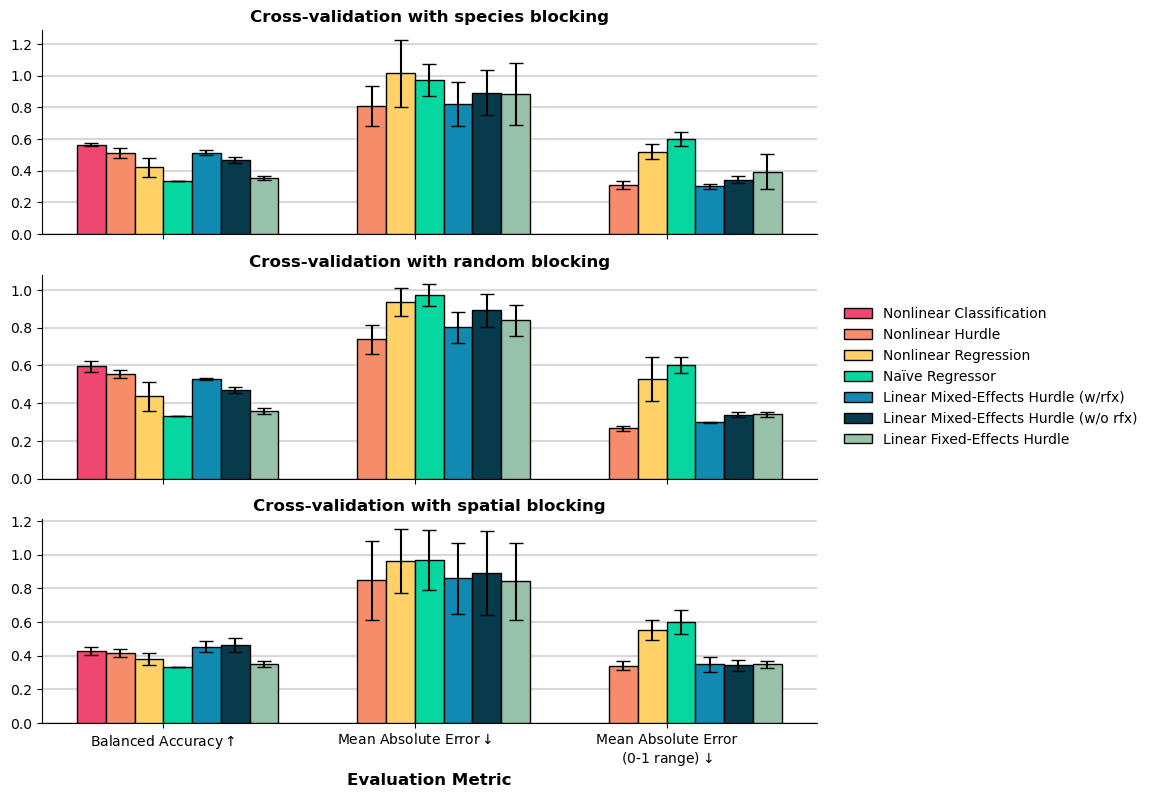

In [70]:
# Plotting results for the above metrics
width = 0.8
plot_rmse = False

metrics = sorted(cv_results[cv_results['model_name'] == 'FLAML_hurdle_2mins']['metric'].unique())
if not plot_rmse:
    metrics.remove('root_mean_squared_error')

model_names_plot = {'FLAML_classification_2mins' : 'Nonlinear Classification', 
                    'FLAML_regression_2mins' : 'Nonlinear Regression',
                    'sklearn_hurdle' : 'Linear Fixed-Effects Hurdle',
                    'pymer_hurdle_w_rfx' : 'Linear Mixed-Effects Hurdle (w/rfx)',
                    'pymer_hurdle_wo_rfx' : 'Linear Mixed-Effects Hurdle (w/o rfx)',
                    'FLAML_hurdle_2mins' : 'Nonlinear Hurdle',
                    'dummy_regressor' : 'Naïve Regressor'}
metric_names_plot = {'balanced_accuracy_overall' : 'Balanced Accuracy$\\uparrow$',
                     'mean_absolute_error' : 'Mean Absolute Error$\\downarrow$',
                     'mean_absolute_error_0-1' : 'Mean Absolute Error\n(0-1 range)$\\downarrow$',
                     'root_mean_squared_error' : 'Root Mean Squared Error$\\downarrow$'}

blocks = cv_results['block_type'].unique()
models = list(cv_results['model_name'].unique())
colors = ['#ef476f', '#f78c6b', '#ffd166', '#06d6a0', '#118ab2', '#073b4c']
if dataset == 'mammals':
    models.remove('sklearn_hurdle')
    models.append('sklearn_hurdle')

    colors.append('#97C1A9')

fig, axs = plt.subplots(3, 1, figsize = (10, 9), sharex = True)

for i, block in enumerate(blocks):
    ax = axs[i]

    ind = np.arange(len(metrics))
    multiplier = 0
    
    for i, model in enumerate(models):
        model_results = cv_results[(cv_results['model_name'] == model) & (cv_results['block_type'] == block) & (cv_results['metric'].isin(metrics))]
        
        means = list(model_results['mean'])
        stds = list(model_results['standard_deviation'])
    
        if model.startswith('FLAML_classification'):
            means.extend([np.nan] * (len(metrics) - 1))
            stds.extend([np.nan] * (len(metrics) - 1))
    
        position = ind + (width / len(models)) * multiplier 
        
        ax.bar(position, means, width / len(models), yerr = stds, capsize = 5, edgecolor = 'black', 
               color = colors[i], label = model_names_plot[model], zorder = 100)
    
        multiplier += 1
    
    ax.set_xticks(ind + (width / 2) - (width / len(models)))
    ax.set_xticklabels([metric_names_plot[m] for m in metrics])

    block_name = 'species' if block == 'group' else block    
    ax.set_title(f'Cross-validation with {block_name} blocking', weight = 'bold', size = 12, pad = 6)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5,
            alpha = 0.3)

axs[1].legend(loc = 'center right', bbox_to_anchor = (1.43, 0.5), ncols = 1, frameon = False)
plt.xlabel('Evaluation Metric', weight = 'bold', size = 12)

# plt.savefig(f'../figures/cv_results_all_blocking_{dataset}.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [74]:
# Highlighting percent improvement in metrics betweeen non-linear vs. linear mixed effects (w/rfx) hurdle
models_to_inspect = ['FLAML_hurdle_2mins', 'pymer_hurdle_wo_rfx', 'dummy_regressor']
cv_subset = cv_results[cv_results['model_name'].isin(models_to_inspect)]

for block in blocks:
    block_name = 'species' if block == 'group' else block  
    print(f'{block_name.upper()} BLOCKING')
    print('----------------')
    for metric in metrics_to_keep:
        mask = (cv_subset['metric'] == metric) & (cv_subset['block_type'] == block)
       
        nonlinear_hurdle = cv_subset[mask & (cv_subset['model_name'] == 'FLAML_hurdle_2mins')]['mean'].iloc[0]
        linear_hurdle = cv_subset[mask & (cv_subset['model_name'] == 'pymer_hurdle_wo_rfx')]['mean'].iloc[0]
        naive_regressor = cv_subset[mask & (cv_subset['model_name'] == 'dummy_regressor')]['mean'].iloc[0]
        
        pct_diff_hurdle = round(((nonlinear_hurdle - linear_hurdle) / linear_hurdle) * 100, 2)
        pct_diff_naive = round(((nonlinear_hurdle - naive_regressor) / naive_regressor) * 100, 2)
        if pct_diff_hurdle > 0:
            pct_diff_hurdle = '+' + str(pct_diff_hurdle)
        if pct_diff_naive > 0:
            pct_diff_naive = '+' + str(pct_diff_naive)
            
        print(f'{metric}: {pct_diff_naive}% (vs. naïve) and {pct_diff_hurdle}% (vs. linear hurdle)')
    print()

SPECIES BLOCKING
----------------
balanced_accuracy_overall: +53.44% (vs. naïve) and +9.19% (vs. linear hurdle)
mean_absolute_error: -16.73% (vs. naïve) and -9.38% (vs. linear hurdle)
mean_absolute_error_0-1: -48.59% (vs. naïve) and -10.13% (vs. linear hurdle)
root_mean_squared_error: +0.53% (vs. naïve) and -1.93% (vs. linear hurdle)

RANDOM BLOCKING
----------------
balanced_accuracy_overall: +66.25% (vs. naïve) and +18.7% (vs. linear hurdle)
mean_absolute_error: -24.1% (vs. naïve) and -17.29% (vs. linear hurdle)
mean_absolute_error_0-1: -55.62% (vs. naïve) and -20.86% (vs. linear hurdle)
root_mean_squared_error: -3.2% (vs. naïve) and -5.09% (vs. linear hurdle)

SPATIAL BLOCKING
----------------
balanced_accuracy_overall: +24.72% (vs. naïve) and -10.41% (vs. linear hurdle)
mean_absolute_error: -12.6% (vs. naïve) and -4.7% (vs. linear hurdle)
mean_absolute_error_0-1: -43.3% (vs. naïve) and -0.55% (vs. linear hurdle)
root_mean_squared_error: +0.4% (vs. naïve) and -1.28% (vs. linear hurd